In [4]:
# Load packages and directories

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_aircon.csv'))  # Change this to your output directory
output_directory = os.path.join(base_directory, 'figures')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

In [5]:
# create combined_df
# Directory containing the household CSV files
data_dir = cleaned_data_directory

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

# Initialize an empty list to store household DataFrames
household_dfs = []

# Iterate through each CSV file in the directory
for filename in os.listdir(data_dir):
    if filename.endswith("_profile.csv"):
        file_path = os.path.join(data_dir, filename)
        
        # Load the household CSV file
        df = pd.read_csv(file_path)
        
        # Convert the 'TS' column to datetime
        df['TS'] = pd.to_datetime(df['TS'])
        
        # Set 'TS' as the index and extract 'Air_Conditioner_Load'
        df = df.set_index('TS')['Air_Conditioner_Load']
        
        # Extract site ID from the filename (assuming the filename format is 'siteid_profile.csv')
        site_id = filename.split('_')[0]
        
        # Rename the column with the site ID for clarity
        df = df.rename(site_id)
        
        # Reindex the household data to match the complete date range
        df = df.reindex(date_range)
        
        # Scale the data using MinMaxScaler for each household
        scaler = MinMaxScaler(feature_range=(0, 1))
        df = pd.DataFrame(scaler.fit_transform(df.values.reshape(-1, 1)), index=df.index, columns=[site_id])
        
        # Append the scaled household data to the list
        household_dfs.append(df)

# Concatenate all household DataFrames along the columns (axis=1)
combined_df = pd.concat(household_dfs, axis=1)

# De-fragment the DataFrame by creating a copy
combined_df = combined_df.copy()

# Reset the index and rename the 'index' column to 'Timestamp'
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index': 'Timestamp'})

# List of IDs to remove
ids_to_remove = [
    'S0024', 'S0159', 'S0318', 'S0444', 'S0470',
    'W0082', 'W0120', 'W0162', 'W0175', 'W0224',
    'W0241', 'W0243', 'W0315', 'W0324', 'W0330', 'W0310', 'W0335', "W0336",
    "W0213", "S0261", 'S0233', 'W0192', 'S0229', 'W0227', 'W0024', 'S0341'
]

# Drop columns based on the list of IDs to remove
combined_df = combined_df.drop(columns=ids_to_remove, errors='ignore')

# # Define the path for the CSV file
# csv_path = os.path.join(base_directory, 'combined_aircon_profiles_normalized.csv')

# # Write to CSV only if the file doesn't already exist
# if not os.path.exists(csv_path):
#     combined_df.to_csv(csv_path, index=False)
#     print(f'File written: {csv_path}')
# else:
#     print('File already exists!')

print(combined_df.head())


            Timestamp     S0083     S0089     S0106     S0107     S0110  \
0 2023-01-01 00:00:00  0.002025  0.000679  0.020532  0.002780  0.000069   
1 2023-01-01 00:30:00  0.002138  0.000665  0.020994  0.002775  0.000074   
2 2023-01-01 01:00:00  0.002522  0.000665  0.020268  0.002746  0.000215   
3 2023-01-01 01:30:00  0.002217  0.000664  0.020807  0.002728  0.000117   
4 2023-01-01 02:00:00  0.002048  0.000662  0.020576  0.002766  0.000077   

      S0111     S0173     S0177     S0179  ...     W0328     W0329     W0332  \
0  0.000465  0.000555  0.000405  0.020569  ...  0.085863  0.003971  0.014980   
1  0.000463  0.000486  0.000396  0.001188  ...  0.086397  0.004002  0.014957   
2  0.000461  0.000519  0.000390  0.009362  ...  0.087665  0.004022  0.014966   
3  0.000461  0.000473  0.000392  0.022880  ...  0.137934  0.004026  0.014803   
4  0.000463  0.000447  0.000375  0.018190  ...  0.125975  0.004014  0.014978   

      W0334     W0341     W0342     W0345     W0346     W0348     W0

In [ ]:
# Visualize one of the sites
# Assuming `combined_df` contains the data with Timestamp and other site IDs
# Filter for the required columns: Timestamp and S0089
df_site_S0089 = combined_df[['Timestamp', 'W0348']]

# Create the plot
fig = go.Figure()

# Add the trace for S0089
fig.add_trace(go.Scatter(x=df_site_S0089['Timestamp'], 
                         y=df_site_S0089['W0348'], 
                         mode='lines',
                         name='S0089',
                         line=dict(color='royalblue', width=2)))

# Set the title and labels
fig.update_layout(
    title='Air Conditioner Load for Site S0089',
    xaxis_title='Timestamp',
    yaxis_title='Air Conditioner Load',
    xaxis=dict(
        tickformat='%Y-%m-%d %H:%M:%S',  # Format for timestamps
        tickmode='auto',
        nticks=10,  # Number of ticks on x-axis
    ),
    yaxis=dict(
        tickformat=".2f"  # Format for y-axis values
    ),
    template='plotly'
)

# Show the plot
fig.show()


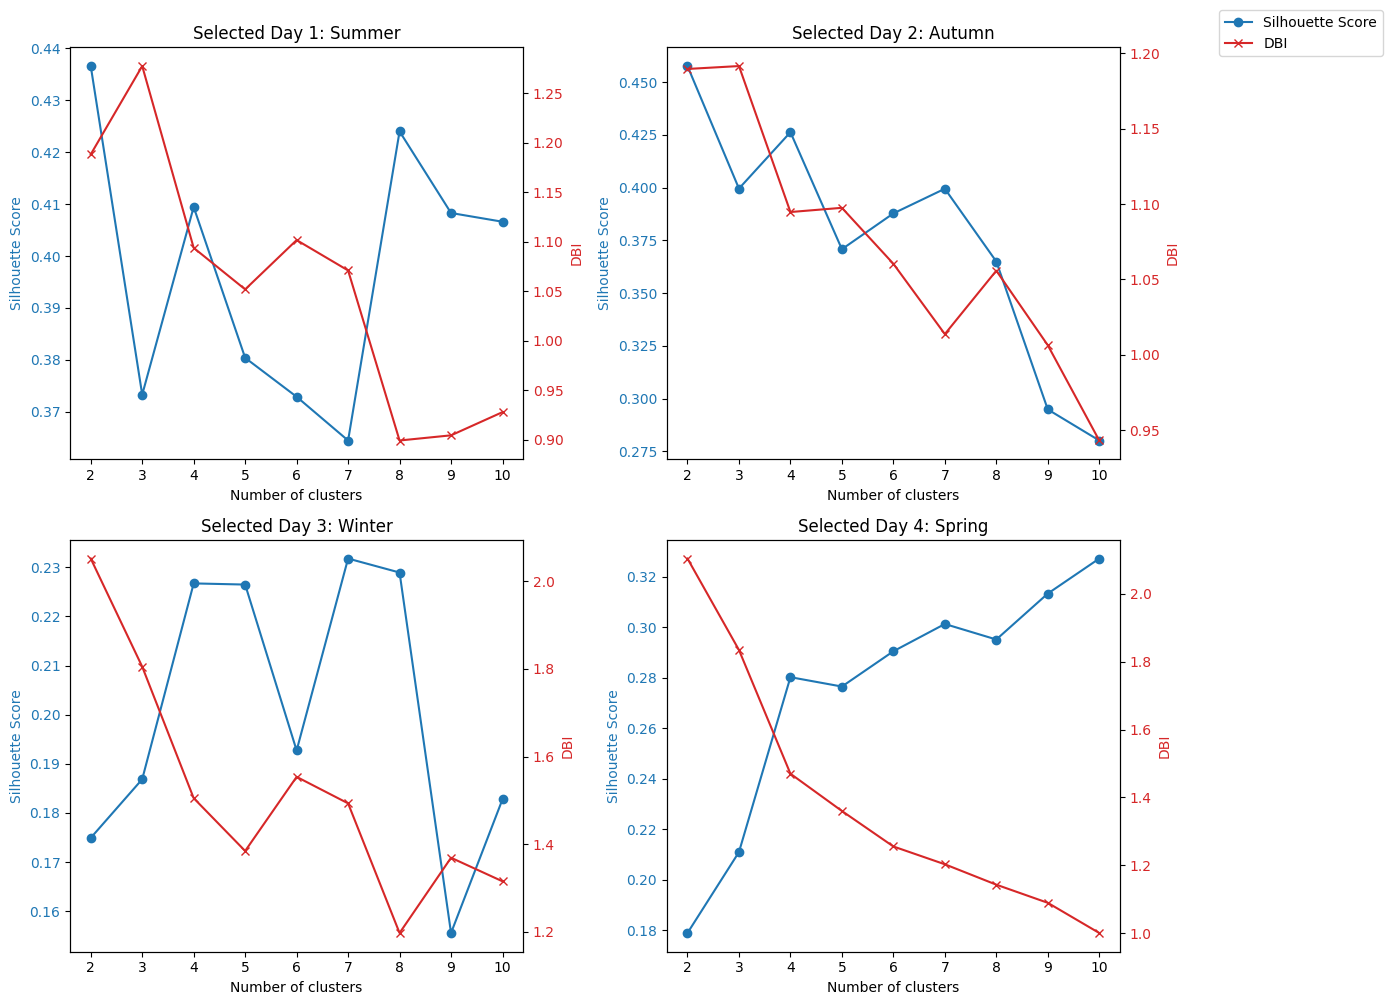

In [24]:
# Determine optimal number of clusters using four randomly selected sites, one for each season, and calculating DBi and silhouette scores


# Function to get season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Function to select random days from each season
def select_random_days(df, seed=42):
    # Set the seed for reproducibility
    random.seed(seed)
    
    # Create a 'Month' and 'Season' column
    df['Month'] = df['Timestamp'].dt.month
    df['Season'] = df['Month'].apply(get_season)
    
    # Create a dictionary to store the random day for each season
    selected_days = {}
    
    for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
        # Filter for the season
        season_df = df[df['Season'] == season]
        
        # Select a random day
        random_day = random.choice(season_df['Timestamp'].dt.date.unique())
        selected_days[season] = random_day
        
    return selected_days


# Function to calculate Silhouette and DBI scores
def kmeans_sil_dbi(num_clusters_range, x_vals):
    sil_scores = []
    dbi_scores = []
    
    
    for k in num_clusters_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x_vals)
        
        # Silhouette score (only valid for k > 1)
        if k > 1:
            sil_scores.append(mt.silhouette_score(x_vals, labels))
        else:
            sil_scores.append(None)
        
        # Davies-Bouldin Index (only valid for k > 1)
        if k > 1:
            dbi_scores.append(mt.davies_bouldin_score(x_vals, labels))
        else:
            dbi_scores.append(None)
    
    return sil_scores, dbi_scores

# Set seed and select random days
selected_days = select_random_days(combined_df, seed=42)

# Create separate DataFrames for each of the four selected days
df_day1 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[0]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')
df_day2 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[1]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')
df_day3 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[2]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')
df_day4 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[3]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')


# List of day names and their corresponding DataFrames
season = [
    (f"Selected Day 1: {list(selected_days.keys())[0]}", df_day1),
    (f"Selected Day 2: {list(selected_days.keys())[1]}", df_day2),
    (f"Selected Day 3: {list(selected_days.keys())[2]}", df_day3),
    (f"Selected Day 4: {list(selected_days.keys())[3]}", df_day4)
]

# Range of clusters to evaluate
num_clusters_range = range(2, 11)

# Create a 2x2 grid for the subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through each day + DataFrame combination
for idx, (day_name, df) in enumerate(season):
    # Drop the 'Timestamp' column for clustering
    x_vals = df

    # Calculate silhouette and DBI for the current dataset
    sil_scores, dbi_scores = kmeans_sil_dbi(num_clusters_range, x_vals)
    
    # Create a dual-axis plot for both Silhouette and DBI
    ax1 = axes[idx]
    
    # Plot silhouette score on the left y-axis
    color1 = 'tab:blue'
    ax1.plot(num_clusters_range, sil_scores, color=color1, marker="o", label="Silhouette Score")
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_title(f'{day_name}')
    
    # Create a second y-axis for DBI
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(num_clusters_range, dbi_scores, color=color2, marker="x", label="DBI")
    ax2.set_ylabel('DBI', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
# Combine both legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage,  single, complete, average, ward, fcluster
from tslearn.metrics import dtw



def compute_distance_matrix(df):
    n_sites = len(df.columns) - 1  # Excluding timestamp column
    distance_matrix = np.zeros((n_sites, n_sites))
    
    for i in range(n_sites):
        for j in range(i+1, n_sites):
            series1 = df.iloc[:, i+1].values  # +1 to skip timestamp column
            series2 = df.iloc[:, j+1].values
            distance_matrix[i, j] = dtw(series1, series2)
            distance_matrix[j, i] = distance_matrix[i, j]  # DTW is symmetric
    
    return distance_matrix

def plot_dendrogram(linkage_matrix):
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Site Index")
    plt.ylabel("Distance")
    plt.show()



def evaluate_clusters(distance_matrix, linkage_matrix, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    
    for n_clusters in range(4, max_clusters + 1):
        labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
        
        silhouette_scores.append(mt.silhouette_score(distance_matrix, labels, metric='precomputed'))
        dbi_scores.append(mt.davies_bouldin_score(distance_matrix, labels))
    
    return silhouette_scores, dbi_scores

def calculate_combined_metric(silhouette_scores, dbi_scores):
    # Normalize scores to [0, 1] range
    scaler = MinMaxScaler()
    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()
    normalized_dbi = scaler.fit_transform(np.array(dbi_scores).reshape(-1, 1)).flatten()
    
    # Invert DBI scores so that higher is better
    inverted_dbi = 1 - normalized_dbi
    
    # Calculate combined metric (simple average)
    combined_metric = (normalized_silhouette + inverted_dbi) / 2
    
    return combined_metric

def plot_scores(silhouette_scores, dbi_scores, combined_metric):
    n_clusters = range(4, len(silhouette_scores) + 4)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    
    ax1.plot(n_clusters, silhouette_scores, 'b-', label='Silhouette Score')
    ax2.plot(n_clusters, dbi_scores, 'r-', label='Davies-Bouldin Score')
    ax3.plot(n_clusters, combined_metric, 'g-', label='Combined Metric')
    
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Score', color='b')
    ax2.set_ylabel('Davies-Bouldin Score', color='r')
    ax3.set_ylabel('Combined Metric', color='g')
    
    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax3.tick_params(axis='y', labelcolor='g')
    
    # Offset the right spine of ax3.  The ticks and label have already been
    # placed on the right by twinx above.
    ax3.spines['right'].set_position(('axes', 1.2))
    
    plt.title('Clustering Evaluation Scores')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.tight_layout()
    plt.show()


def optimize_clusters_for_day(day_df, max_clusters=10): 
    distance_matrix = compute_distance_matrix(day_df.dropna(axis=1, how='all'))
    linkage_matrix = linkage(distance_matrix, method='ward') 
    silhouette_scores, dbi_scores = evaluate_clusters(distance_matrix, linkage_matrix, max_clusters) 
    # Normalize scores 
    scaler = MinMaxScaler() 
    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten() 
    normalized_dbi = scaler.fit_transform(np.array(dbi_scores).reshape(-1, 1)).flatten() 
    # Invert DBI scores so that higher is better 
    inverted_dbi = 1 - normalized_dbi 
    
    # Calculate combined metric (simple average) 
    combined_metric = (normalized_silhouette + inverted_dbi) / 2 
    
    # Find the optimal number of clusters 
    optimal_clusters = combined_metric.argmax() + 4 # +2 because we start from 2 clusters return optimal_clusters 
    return optimal_clusters

def main(df):

    # Load your data
    df = df
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])   

    daily_optimal_clusters = []
    for date, day_df in df.groupby(df['Timestamp'].dt.date): 
        optimal_clusters = optimize_clusters_for_day(day_df) 
        daily_optimal_clusters.append({'Date': date, 'OptimalClusters': optimal_clusters}) # Create DataFrame with results 
        results_df = pd.DataFrame(daily_optimal_clusters) 
        results_df['Date'] = pd.to_datetime(results_df['Date']) 
        # results_df = results_df.sort_values('Date') # Save results to CSV 
        # results_df.to_csv('daily_optimal_clusters.csv', index=False) 
        print("Daily optimal clusters processed for date:", date) 
    return results_df 

cleaned_combined_df = combined_df.drop(columns=['Month', 'Season'])

clipped_df = cleaned_combined_df[(cleaned_combined_df['Timestamp'] >= '2023-03-01') & (cleaned_combined_df['Timestamp'] <= '2023-04-30')]

results_df = main(clipped_df)


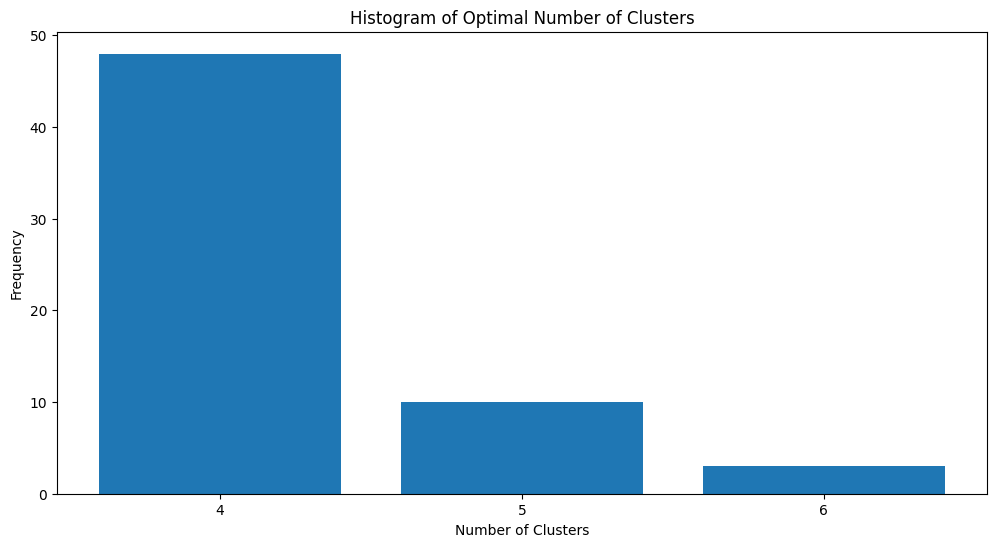

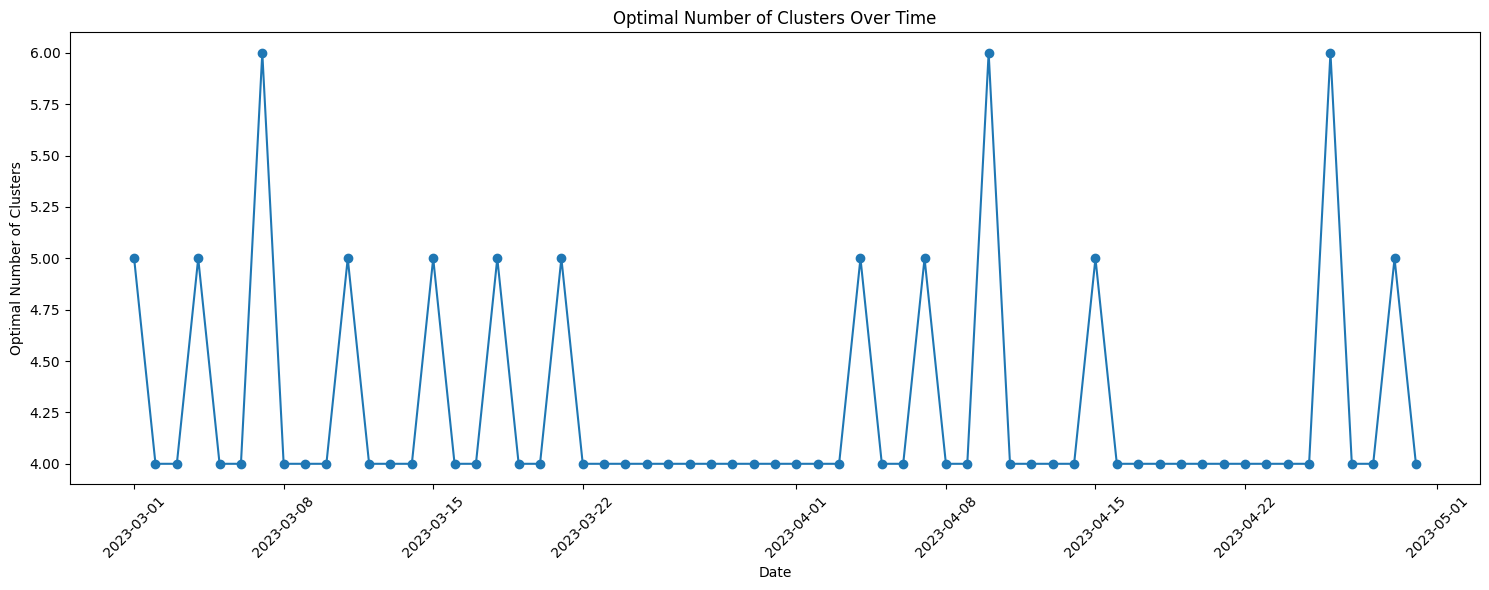

In [69]:

# Plot histogram 
plt.figure(figsize=(12, 6)) 
plt.hist(results_df['OptimalClusters'], bins=range(min(results_df['OptimalClusters']), max(results_df['OptimalClusters'])+2, 1), align='left', rwidth=0.8) 
plt.title('Histogram of Optimal Number of Clusters') 
plt.xlabel('Number of Clusters') 
plt.ylabel('Frequency') 
plt.xticks(range(min(results_df['OptimalClusters']), max(results_df['OptimalClusters'])+1)) 
plt.show()

#Plot line graph 
plt.figure(figsize=(15, 6)) 
plt.plot(results_df['Date'], results_df['OptimalClusters'], marker='o') 
plt.title('Optimal Number of Clusters Over Time') 
plt.xlabel('Date') 
plt.ylabel('Optimal Number of Clusters') 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [54]:
print(results_df.head())

        Date  OptimalClusters
0 2023-01-01                3
1 2023-01-02                3
2 2023-01-03                3
3 2023-01-04                4
4 2023-01-05                4


In [85]:
print(cleaned_combined_df.head())

            Timestamp     S0083     S0089     S0106     S0107     S0110  \
0 2023-01-01 00:00:00  0.002025  0.000679  0.020532  0.002780  0.000069   
1 2023-01-01 00:30:00  0.002138  0.000665  0.020994  0.002775  0.000074   
2 2023-01-01 01:00:00  0.002522  0.000665  0.020268  0.002746  0.000215   
3 2023-01-01 01:30:00  0.002217  0.000664  0.020807  0.002728  0.000117   
4 2023-01-01 02:00:00  0.002048  0.000662  0.020576  0.002766  0.000077   

      S0111     S0173     S0177     S0179  ...     W0328     W0329     W0332  \
0  0.000465  0.000555  0.000405  0.020569  ...  0.085863  0.003971  0.014980   
1  0.000463  0.000486  0.000396  0.001188  ...  0.086397  0.004002  0.014957   
2  0.000461  0.000519  0.000390  0.009362  ...  0.087665  0.004022  0.014966   
3  0.000461  0.000473  0.000392  0.022880  ...  0.137934  0.004026  0.014803   
4  0.000463  0.000447  0.000375  0.018190  ...  0.125975  0.004014  0.014978   

      W0334     W0341     W0342     W0345     W0346     W0348     W0

In [91]:

from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clusters(X, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    
    for n_clusters in range(4, max_clusters + 1):
        kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
        labels = kmeans.fit_predict(X)
        
        silhouette_scores.append(silhouette_score(X, labels))
        dbi_scores.append(davies_bouldin_score(X, labels))
    
    return silhouette_scores, dbi_scores

def calculate_combined_metric(silhouette_scores, dbi_scores):
    scaler = MinMaxScaler()
    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()
    normalized_dbi = scaler.fit_transform(np.array(dbi_scores).reshape(-1, 1)).flatten()
    
    inverted_dbi = 1 - normalized_dbi
    combined_metric = (normalized_silhouette + inverted_dbi) / 2
    
    return combined_metric

def optimize_clusters_for_day(day_df, max_clusters=10):
    day_df_cleaned = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all')
    
    if day_df_cleaned.shape[1] <= 1:
        print(f"Skipping clustering for {day_df['Timestamp'].dt.date.iloc[0]} due to insufficient data.")
        return None

    X = day_df_cleaned.values.T  # Transpose to get (n_samples, n_timestamps)

    silhouette_scores, dbi_scores = evaluate_clusters(X, max_clusters)
    combined_metric = calculate_combined_metric(silhouette_scores, dbi_scores)
    
    optimal_clusters = combined_metric.argmax() + 4  # +4 because we start from 4 clusters
    optimal_silhouette = silhouette_scores[optimal_clusters - 4]
    optimal_dbi = dbi_scores[optimal_clusters - 4]
    optimal_score = combined_metric[optimal_clusters - 4]
    
    return optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi

def main(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    daily_results = []
    for date, day_df in df.groupby(df['Timestamp'].dt.date):
        print(f"Processing date: {date}, data shape: {day_df.shape}")
        optimal_result = optimize_clusters_for_day(day_df)
        
        if optimal_result is not None:
            optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi = optimal_result
            daily_results.append({
                'Date': date,
                'DTW_OptimalClusters': optimal_clusters,
                'DTW_Score': optimal_score,
                'DTW_Silhouette': optimal_silhouette,
                'DTW_DBI': optimal_dbi
            })
        else:
            daily_results.append({
                'Date': date,
                'DTW_OptimalClusters': None,
                'DTW_Score': None,
                'DTW_Silhouette': None,
                'DTW_DBI': None
            })

    results_df = pd.DataFrame(daily_results)
    results_df['Date'] = pd.to_datetime(results_df['Date'])
    results_df = results_df.sort_values('Date')
    
    print("Daily optimal clusters comparison processed.")
    return results_df

# Example usage
cleaned_combined_df = combined_df.drop(columns=['Month', 'Season'])
clipped_df = cleaned_combined_df[(cleaned_combined_df['Timestamp'] >= '2023-03-01') & (cleaned_combined_df['Timestamp'] <= '2023-03-05 23:30:00')]
results_df = main(clipped_df)
print(results_df)

C:\Users\CEEM04\AppData\Local\Temp\ipykernel_9400\251630479.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing date: 2023-03-01, data shape: (48, 222)
Processing date: 2023-03-02, data shape: (48, 222)
Processing date: 2023-03-03, data shape: (48, 222)
Processing date: 2023-03-04, data shape: (48, 222)
Processing date: 2023-03-05, data shape: (48, 222)
Daily optimal clusters comparison processed.
        Date  DTW_OptimalClusters  DTW_Score  DTW_Silhouette   DTW_DBI
0 2023-03-01                    4   1.000000        0.568168  2.141642
1 2023-03-02                    4   0.985112        0.553398  2.316830
2 2023-03-03                    4   1.000000        0.584427  1.941993
3 2023-03-04                    5   1.000000        0.516608  1.818783
4 2023-03-05                    8   0.504437        0.296775  3.759449


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score 

from tslearn.clustering import TimeSeriesKMeans 

from sklearn_extra.cluster import KMedoids 

  

def evaluate_clusters_dtw(X, max_clusters=10): 

    silhouette_scores = [] 

    dbi_scores = [] 

     

    for n_clusters in range(4, max_clusters + 1): 

        kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42) 

        labels = kmeans.fit_predict(X) 

         

        silhouette_scores.append(silhouette_score(X, labels)) 

        dbi_scores.append(davies_bouldin_score(X, labels)) 

     

    return silhouette_scores, dbi_scores 

  

def evaluate_clusters_kmedoids(X, max_clusters=10): 

    silhouette_scores = [] 

    dbi_scores = [] 

     

    for n_clusters in range(4, max_clusters + 1): 

        kmedoids = KMedoids(n_clusters=n_clusters, metric="euclidean", random_state=42) 

        labels = kmedoids.fit_predict(X) 

         

        silhouette_scores.append(silhouette_score(X, labels)) 

        dbi_scores.append(davies_bouldin_score(X, labels)) 

     

    return silhouette_scores, dbi_scores 

  

def calculate_combined_metric(silhouette_scores, dbi_scores): 

    scaler = MinMaxScaler() 

    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten() 

    normalized_dbi = scaler.fit_transform(np.array(dbi_scores).reshape(-1, 1)).flatten() 

     

    inverted_dbi = 1 - normalized_dbi 

    combined_metric = (normalized_silhouette + inverted_dbi) / 2 

     

    return combined_metric 

  

def optimize_clusters_for_day(day_df, max_clusters=10): 

    day_df_cleaned = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all') 

     

    if day_df_cleaned.shape[1] <= 1: 

        print(f"Skipping clustering for {day_df['Timestamp'].dt.date.iloc[0]} due to insufficient data.") 

        return None 

  

    X_dtw = day_df_cleaned.values.T  # Transpose for DTW 

    X_kmedoids = day_df_cleaned.values  # No transpose for k-medoids 

  

    # DTW clustering 

    silhouette_scores_dtw, dbi_scores_dtw = evaluate_clusters_dtw(X_dtw, max_clusters) 

    combined_metric_dtw = calculate_combined_metric(silhouette_scores_dtw, dbi_scores_dtw) 

     

    optimal_clusters_dtw = combined_metric_dtw.argmax() + 4 

    optimal_silhouette_dtw = silhouette_scores_dtw[optimal_clusters_dtw - 4] 

    optimal_dbi_dtw = dbi_scores_dtw[optimal_clusters_dtw - 4] 

    optimal_score_dtw = combined_metric_dtw[optimal_clusters_dtw - 4] 

  

    # K-Medoids clustering 

    silhouette_scores_kmedoids, dbi_scores_kmedoids = evaluate_clusters_kmedoids(X_kmedoids, max_clusters) 

    combined_metric_kmedoids = calculate_combined_metric(silhouette_scores_kmedoids, dbi_scores_kmedoids) 

     

    optimal_clusters_kmedoids = combined_metric_kmedoids.argmax() + 4 

    optimal_silhouette_kmedoids = silhouette_scores_kmedoids[optimal_clusters_kmedoids - 4] 

    optimal_dbi_kmedoids = dbi_scores_kmedoids[optimal_clusters_kmedoids - 4] 

    optimal_score_kmedoids = combined_metric_kmedoids[optimal_clusters_kmedoids - 4] 

     

    return (optimal_clusters_dtw, optimal_score_dtw, optimal_silhouette_dtw, optimal_dbi_dtw, 

            optimal_clusters_kmedoids, optimal_score_kmedoids, optimal_silhouette_kmedoids, optimal_dbi_kmedoids) 

  

def main(df): 

    df['Timestamp'] = pd.to_datetime(df['Timestamp']) 

     

    daily_results = [] 

    for date, day_df in df.groupby(df['Timestamp'].dt.date): 

        print(f"Processing date: {date}, data shape: {day_df.shape}") 

        optimal_result = optimize_clusters_for_day(day_df) 

         

        if optimal_result is not None: 

            (optimal_clusters_dtw, optimal_score_dtw, optimal_silhouette_dtw, optimal_dbi_dtw, 

             optimal_clusters_kmedoids, optimal_score_kmedoids, optimal_silhouette_kmedoids, optimal_dbi_kmedoids) = optimal_result 

             

            daily_results.append({ 

                'Date': date, 
                'DTW_OptimalClusters': optimal_clusters_dtw, 
                'DTW_Score': optimal_score_dtw, 
                'DTW_Silhouette': optimal_silhouette_dtw, 
                'DTW_DBI': optimal_dbi_dtw, 
                'KMedoids_OptimalClusters': optimal_clusters_kmedoids, 
                'KMedoids_Score': optimal_score_kmedoids, 
                'KMedoids_Silhouette': optimal_silhouette_kmedoids, 
                'KMedoids_DBI': optimal_dbi_kmedoids 

            }) 

        else: 

            daily_results.append({ 

                'Date': date, 
                'DTW_OptimalClusters': None, 
                'DTW_Score': None, 
                'DTW_Silhouette': None, 
                'DTW_DBI': None, 
                'KMedoids_OptimalClusters': None, 
                'KMedoids_Score': None, 
                'KMedoids_Silhouette': None, 
                'KMedoids_DBI': None 

            }) 

  

    results_df = pd.DataFrame(daily_results) 
    results_df['Date'] = pd.to_datetime(results_df['Date']) 
    results_df = results_df.sort_values('Date') 
    print("Daily optimal clusters comparison processed.") 
    return results_df 

  

# Example usage 

cleaned_combined_df = combined_df.drop(columns=['Month', 'Season']) 
clipped_df = cleaned_combined_df[(cleaned_combined_df['Timestamp'] >= '2023-03-01') & (cleaned_combined_df['Timestamp'] <= '2023-04-30')] 
results_df = main(clipped_df) 
print(results_df) 

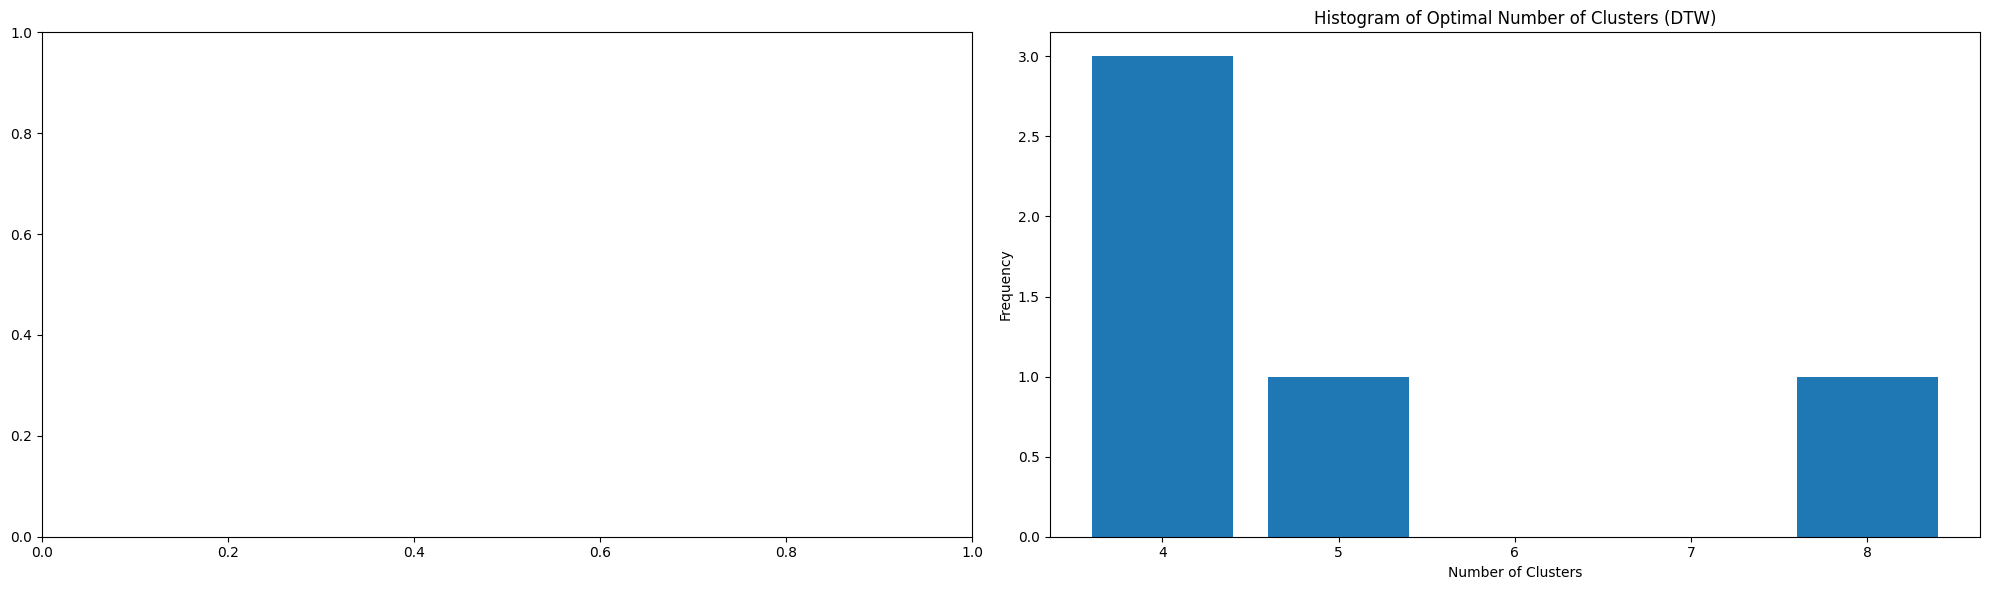

KeyError: 'KMeans_OptimalClusters'

<Figure size 1500x600 with 0 Axes>

In [93]:

# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(results_df['DTW_OptimalClusters'], bins=range(min(results_df['DTW_OptimalClusters']), max(results_df['KMeans_OptimalClusters'])+2, 1), 
            align='left', rwidth=0.8)
ax1.set_title('Histogram of Optimal Number of Clusters (K-means)')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(min(results_df['KMeans_OptimalClusters']), max(results_df['KMeans_OptimalClusters'])+1))

ax2.hist(results_df['DTW_OptimalClusters'], bins=range(min(results_df['DTW_OptimalClusters']), max(results_df['DTW_OptimalClusters'])+2, 1), 
            align='left', rwidth=0.8)
ax2.set_title('Histogram of Optimal Number of Clusters (DTW)')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(min(results_df['DTW_OptimalClusters']), max(results_df['DTW_OptimalClusters'])+1))

plt.tight_layout()
plt.show()


# Plot line graphs
plt.figure(figsize=(15, 6))
plt.plot(results_df['Date'], results_df['KMeans_OptimalClusters'], marker='o', label='K-means')
plt.plot(results_df['Date'], results_df['DTW_OptimalClusters'], marker='s', label='DTW')
plt.title('Optimal Number of Clusters Over Time')
plt.xlabel('Date')
plt.ylabel('Optimal Number of Clusters')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    



In [61]:
# Filter the DataFrame to only include rows where the date is '2023-01-01'
df_jan1 = combined_df[combined_df['Timestamp'].dt.date == pd.to_datetime('2023-01-01').date()]
df_jan1 = df_jan1.drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')
# Display the subset

In [62]:
prep = to_time_series_dataset(df_jan1.T.values)
print(prep.shape)

(221, 48, 1)


In [63]:
seed = 0
np.random.seed(seed)
#prep = TimeSeriesScalerMinMax().fit_transform(prep)


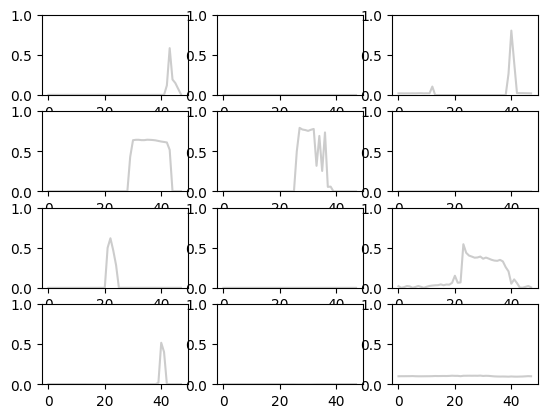

In [64]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(prep[yi].ravel(), "k-", alpha=.2)
    plt.ylim(0,1)
    plt.rcParams['figure.figsize'] = [12, 10]

#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

Euclidean k-means


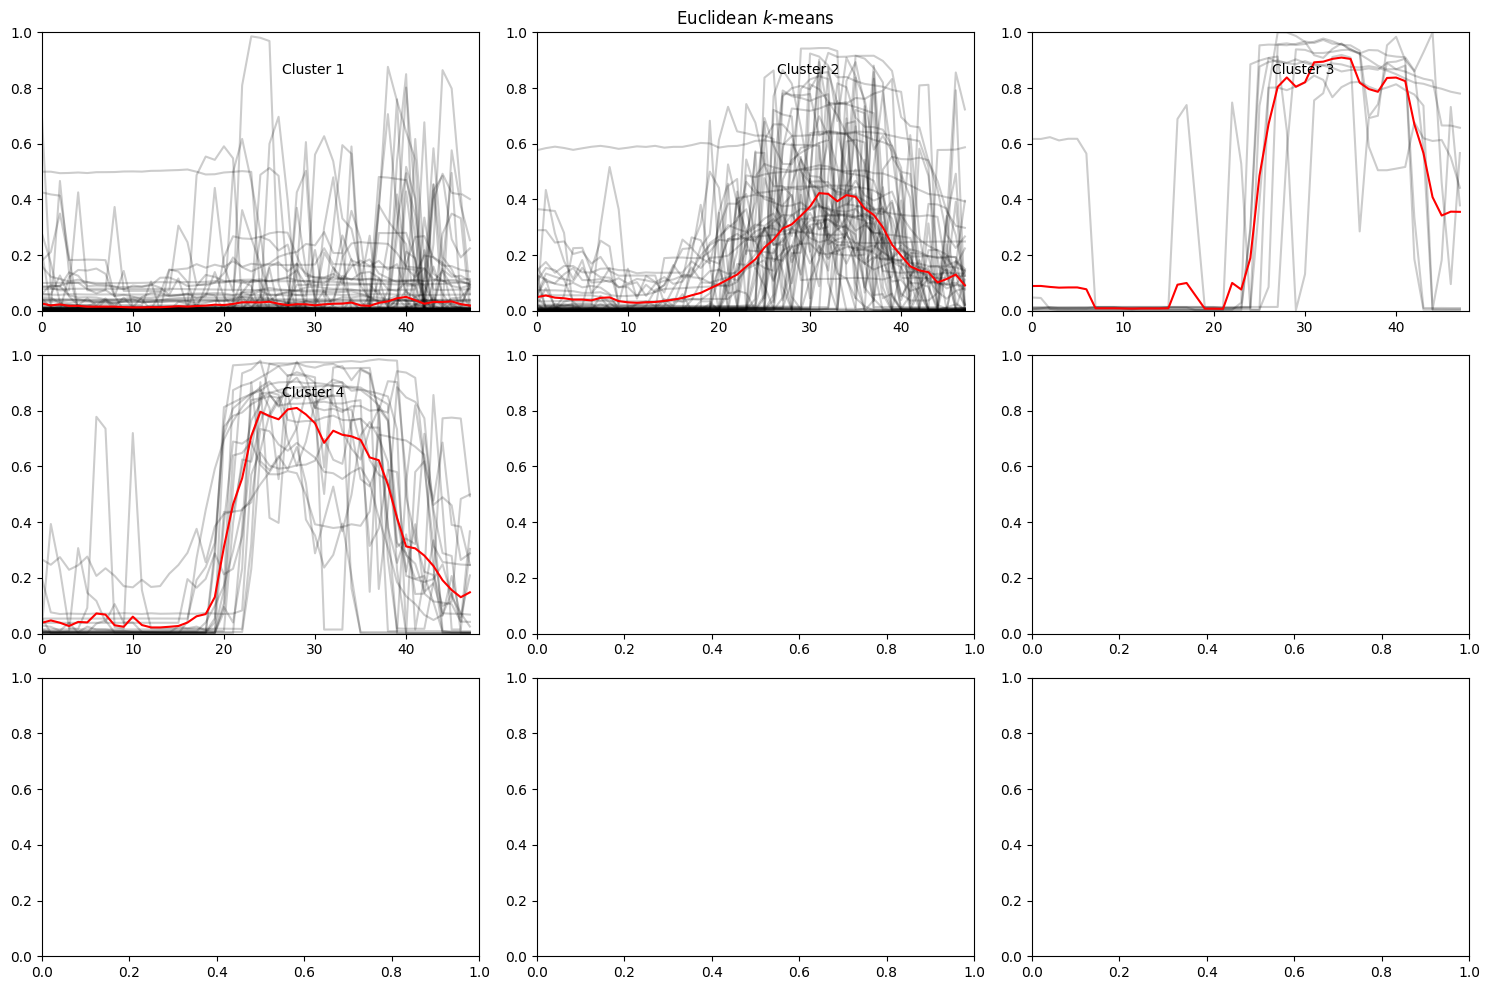

In [67]:
X_train = prep
n_clusters = 4
sz = X_train.shape[1]
seed = 0

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X_train)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for yi in range(n_clusters):
    # Get the current axis from the 3x3 grid
    ax = axes[yi // 3, yi % 3]
    
    # Plot all curves for the current cluster
    for xx in X_train[y_pred_km == yi]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    
    # Plot the cluster center
    ax.plot(km.cluster_centers_[yi].ravel(), "r-")
    
    # Set plot limits
    ax.set_xlim(0, sz)
    ax.set_ylim(0, 1)
    
    # Add cluster label text
    ax.text(0.55, 0.85, 'Cluster %d' % (yi + 1), transform=ax.transAxes)
    
    # Set title only for the first cluster
    if yi == 1:
        ax.set_title("Euclidean $k$-means")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

DBA k-means
DBA silhoutte: 0.50
Euclidean silhoutte: 0.49


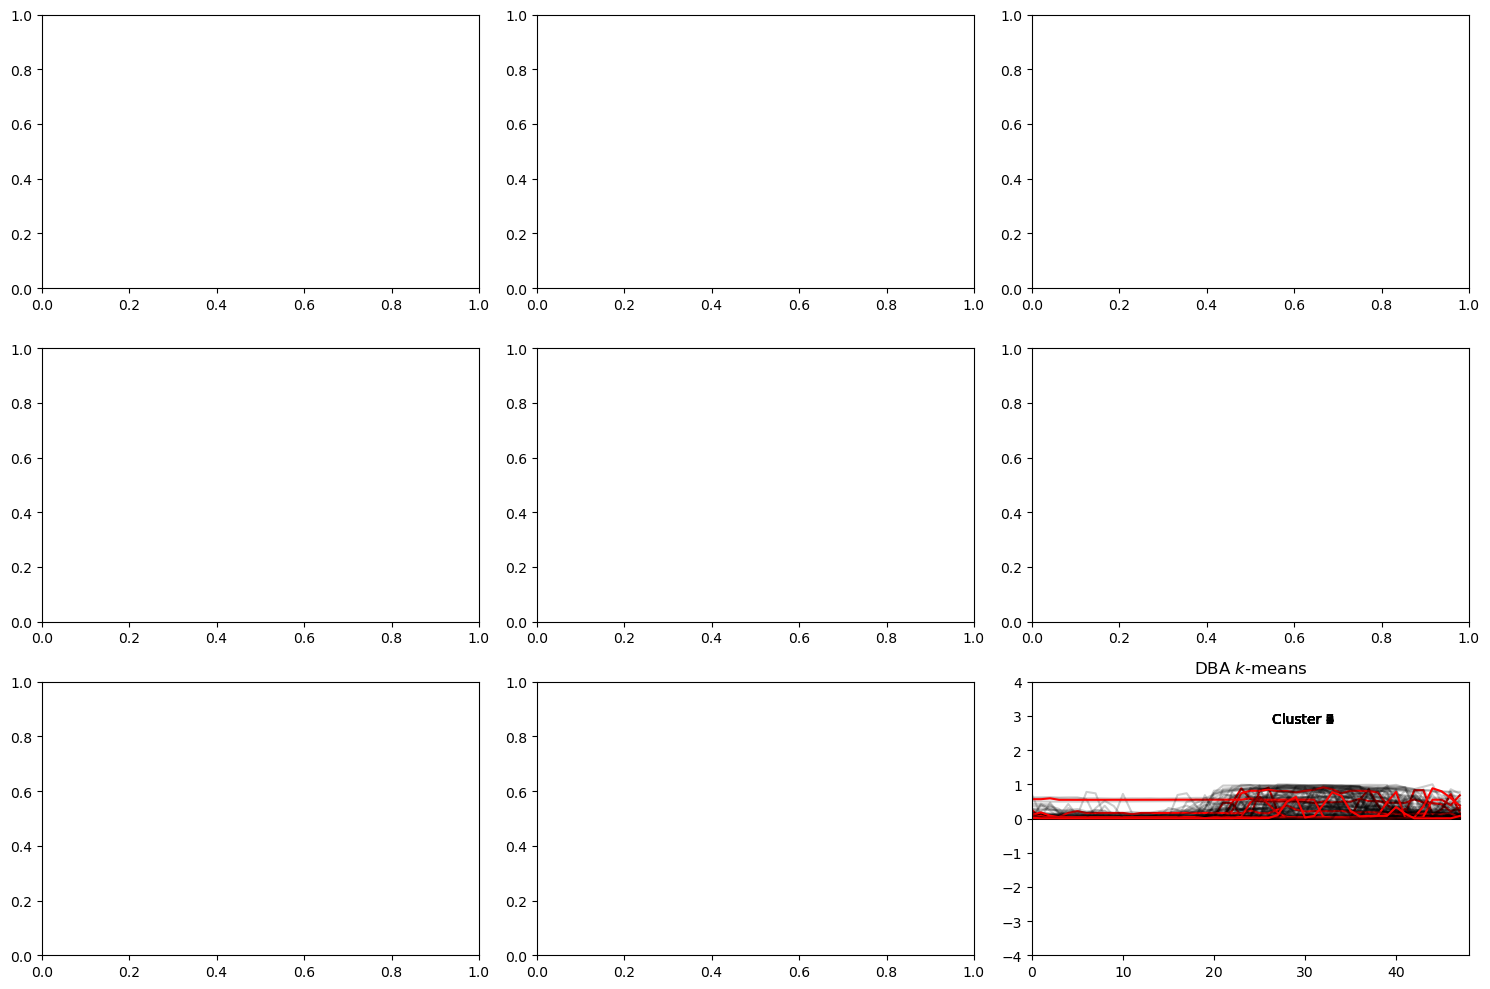

In [73]:
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))



print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for yi in range(n_clusters):
    # Get the current axis from the 3x3 grid
    ax = axes[yi // 3, yi % 3]
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

In [ ]:
num_clusters = 6

def cluster(x, num_clusters):
    y=x.T # Since we need to assign households to clusters and not hour of the day, the dataframe is transposed
    cluster = KMeans(n_clusters=num_clusters, random_state=42)
    # Adding a new column 'cluster_number' containing cluster assignment (0, 1 or 2) for each household.
    y['cluster_number']=cluster.fit_predict(y[y.columns[0:]])
    y.name = x.name
    return y


s_wd_cl = cluster(df_jan1, num_clusters)